## Evaluating the  Models 

### Primary Goal: Evaluate the ML and BL models

In this notebook, I'll provide a brief tutorial on how to evaluate the final machine learning (ML) and baseline (BL) models. 

In [59]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
#sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
sys.path.append('/home/samuel.varga/python_packages/verification_diagrams')
from main.io import load_ml_data, load_bl_data
from verification_diagrams._plot import plot_verification
#from main.verification import plot_verification 
from VargaPy.MlUtils import All_Severe, Drop_Unwanted_Variables

In [127]:
# Configuration variables (You'll need to change based on where you store your data)
FRAMEWORK='POTVIN'
TIMESCALE='2to6'
data_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'

<div class="alert alert-block alert-danger"> <b>CAUTION</b> We are evaluating the models, so mode must be set to 'test' in load_ml_data or load_bl_data </div>

### Step 1. Load the ML and Baseline Testing Datasets

In [136]:
# Set the target column 
hazard='all' #Use tornado to get 0-2UH Baseline
scale='18km' #9,18,36 #Target scale
ts='all' #Training scale
target_col=f'{hazard}_severe__{scale}' 
# Set the mode == test so as to load the testing dataset. 
mode='test'
SigSevere=False



if hazard=='all': #Use all severe as target
    
    X, y, metadata = All_Severe(base_path=data_path, mode=mode, target_scale=scale[0:-2:1], 
                                FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, SigSevere=SigSevere, appendUH=False)

else:
    X,y,metadata = load_ml_data(base_path=data_path, 
                            mode=mode, 
                            target_col=target_col, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)



# Load the testing dataset for the baseline model. 
# The baseline and machine learning models are 
# using the same target values so we do not need 
# initialize the baseline target values. 
bl_df, _, _ = load_bl_data(base_path=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/POTVIN', 
                             mode=mode, 
                             target_col=f'{hazard}_severe__{scale}' if hazard!= 'all' else f'tornado_severe__{scale}',
                           TIMESCALE=TIMESCALE, Big=False
                            )
bl_col = {'0to3':{'hail_severe' :  'hailcast__nmep_>1_25_45km',
          'wind_severe' : 'ws_80__nmep_>40_27km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>175_27km',
            'all_severe' : 'uh_2to5_instant__nmep_>150_27km'
         },
    '2to6':{'hail_severe' :  'hailcast__nmep_>1_25_45km',
          'wind_severe' : 'ws_80__nmep_>50_45km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>200_27km',
            'all_severe' : 'uh_2to5_instant__nmep_>150_27km'
         }} #200, 27 for Sig Sev || 150, 27 for Sev

##2-6:
#36: 150, 45
#18: 150, 27
#9: 175, 27

##0-3:
#36:100, 27
#18:150,27
#9:75, 9



#(66309 ,31127)||(15220,6082)
# Get the X input into the baseline model. 

X_bl = bl_df[bl_col[TIMESCALE][target_col.split('__')[0]]]

6603
10859
11817


In [137]:
X, ts_suff, var_suff = Drop_Unwanted_Variables(X, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=True, envOnly=False)
print(var_suff)

Using new variables- dropping old 90th percentile
Dropping all environmental variables
(638464, 96)
all
intrastorm


### Step 2. Load the ML and Baseline models. 

In [138]:
#base_path = f'/work/mflora/ML_2TO6HR/models/'
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
model_ind=0

# Load the ML model.
#ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))
ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}.joblib'))
bl_model=joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{hazard}_baseline_model_{"sig_" if SigSevere else ""}{scale}.joblib'))
# When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
# there are additional metadata that is stored with it. 
# We want to load the model and the features. 
# We want to make sure the X input as the features in correct order. 
ml_model = ml_data['model']
features = ml_data['X'].columns

ml_models = [ml_model] 

for name in ['logistic']:#,'random','ADAM','wac']: #Adds the Logistic and random models to the list
    #ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))
    ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}.joblib'))
    ml_model = ml_data['model']
    ml_models.append(ml_model)
    
names = ['Hist', 'Logistic']#,,'RF-A&L HP' 'Random','ADAM','WAC'] 
estimators = [(name, model) for name, model in zip(names, ml_models)]
X = X[features]

In [139]:
#metadata['Init Time'].unique().astype(int)/100
#metadata['Init Time'].astype(int)/100 %4
def init_time_to_groups(init_times):
    '''Converts init times to four groups separated by 4 hours'''
    init_times=init_times.astype(int)/100 #Divide by 100 to remove trailing zeros
    init_times = init_times % 4
    return init_times
groups = init_time_to_groups(metadata['Init Time'])    

In [140]:
def get_ml_pred(X, estimator):
    model=estimator[1]
    ml_pred=model.predict_proba(X)[:,1]
    return ml_pred
y_hat=[get_ml_pred(X, estimator) for estimator in estimators]

In [141]:
def get_bl_pred(X_baseline, bl_model):
    bl_model=bl_model[1]
    bl_preds=predictions = bl_model.predict(X_baseline.reshape(-1, 1))
    return bl_preds
estimators.append(('BL',bl_model))
y_hat.append(get_bl_pred(X_bl.values,('BL',bl_model)))
y_hat = [y_s.reshape(len(y),) for y_s in y_hat]

In [142]:
print(np.shape(y_hat))

(3, 638464)


### Step 3. Evaluate the ML and Baseline models using Reliability, Performance, and ROC Diagrams

(<Figure size 2400x2400 with 5 Axes>,
 array([[<AxesSubplot:xlabel='Mean Forecast Probability', ylabel='Conditional Event Frequency'>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='Success Ratio (SR; 1-FAR)', ylabel='Probability of Detection (POD)'>,
         <AxesSubplot:>]], dtype=object))

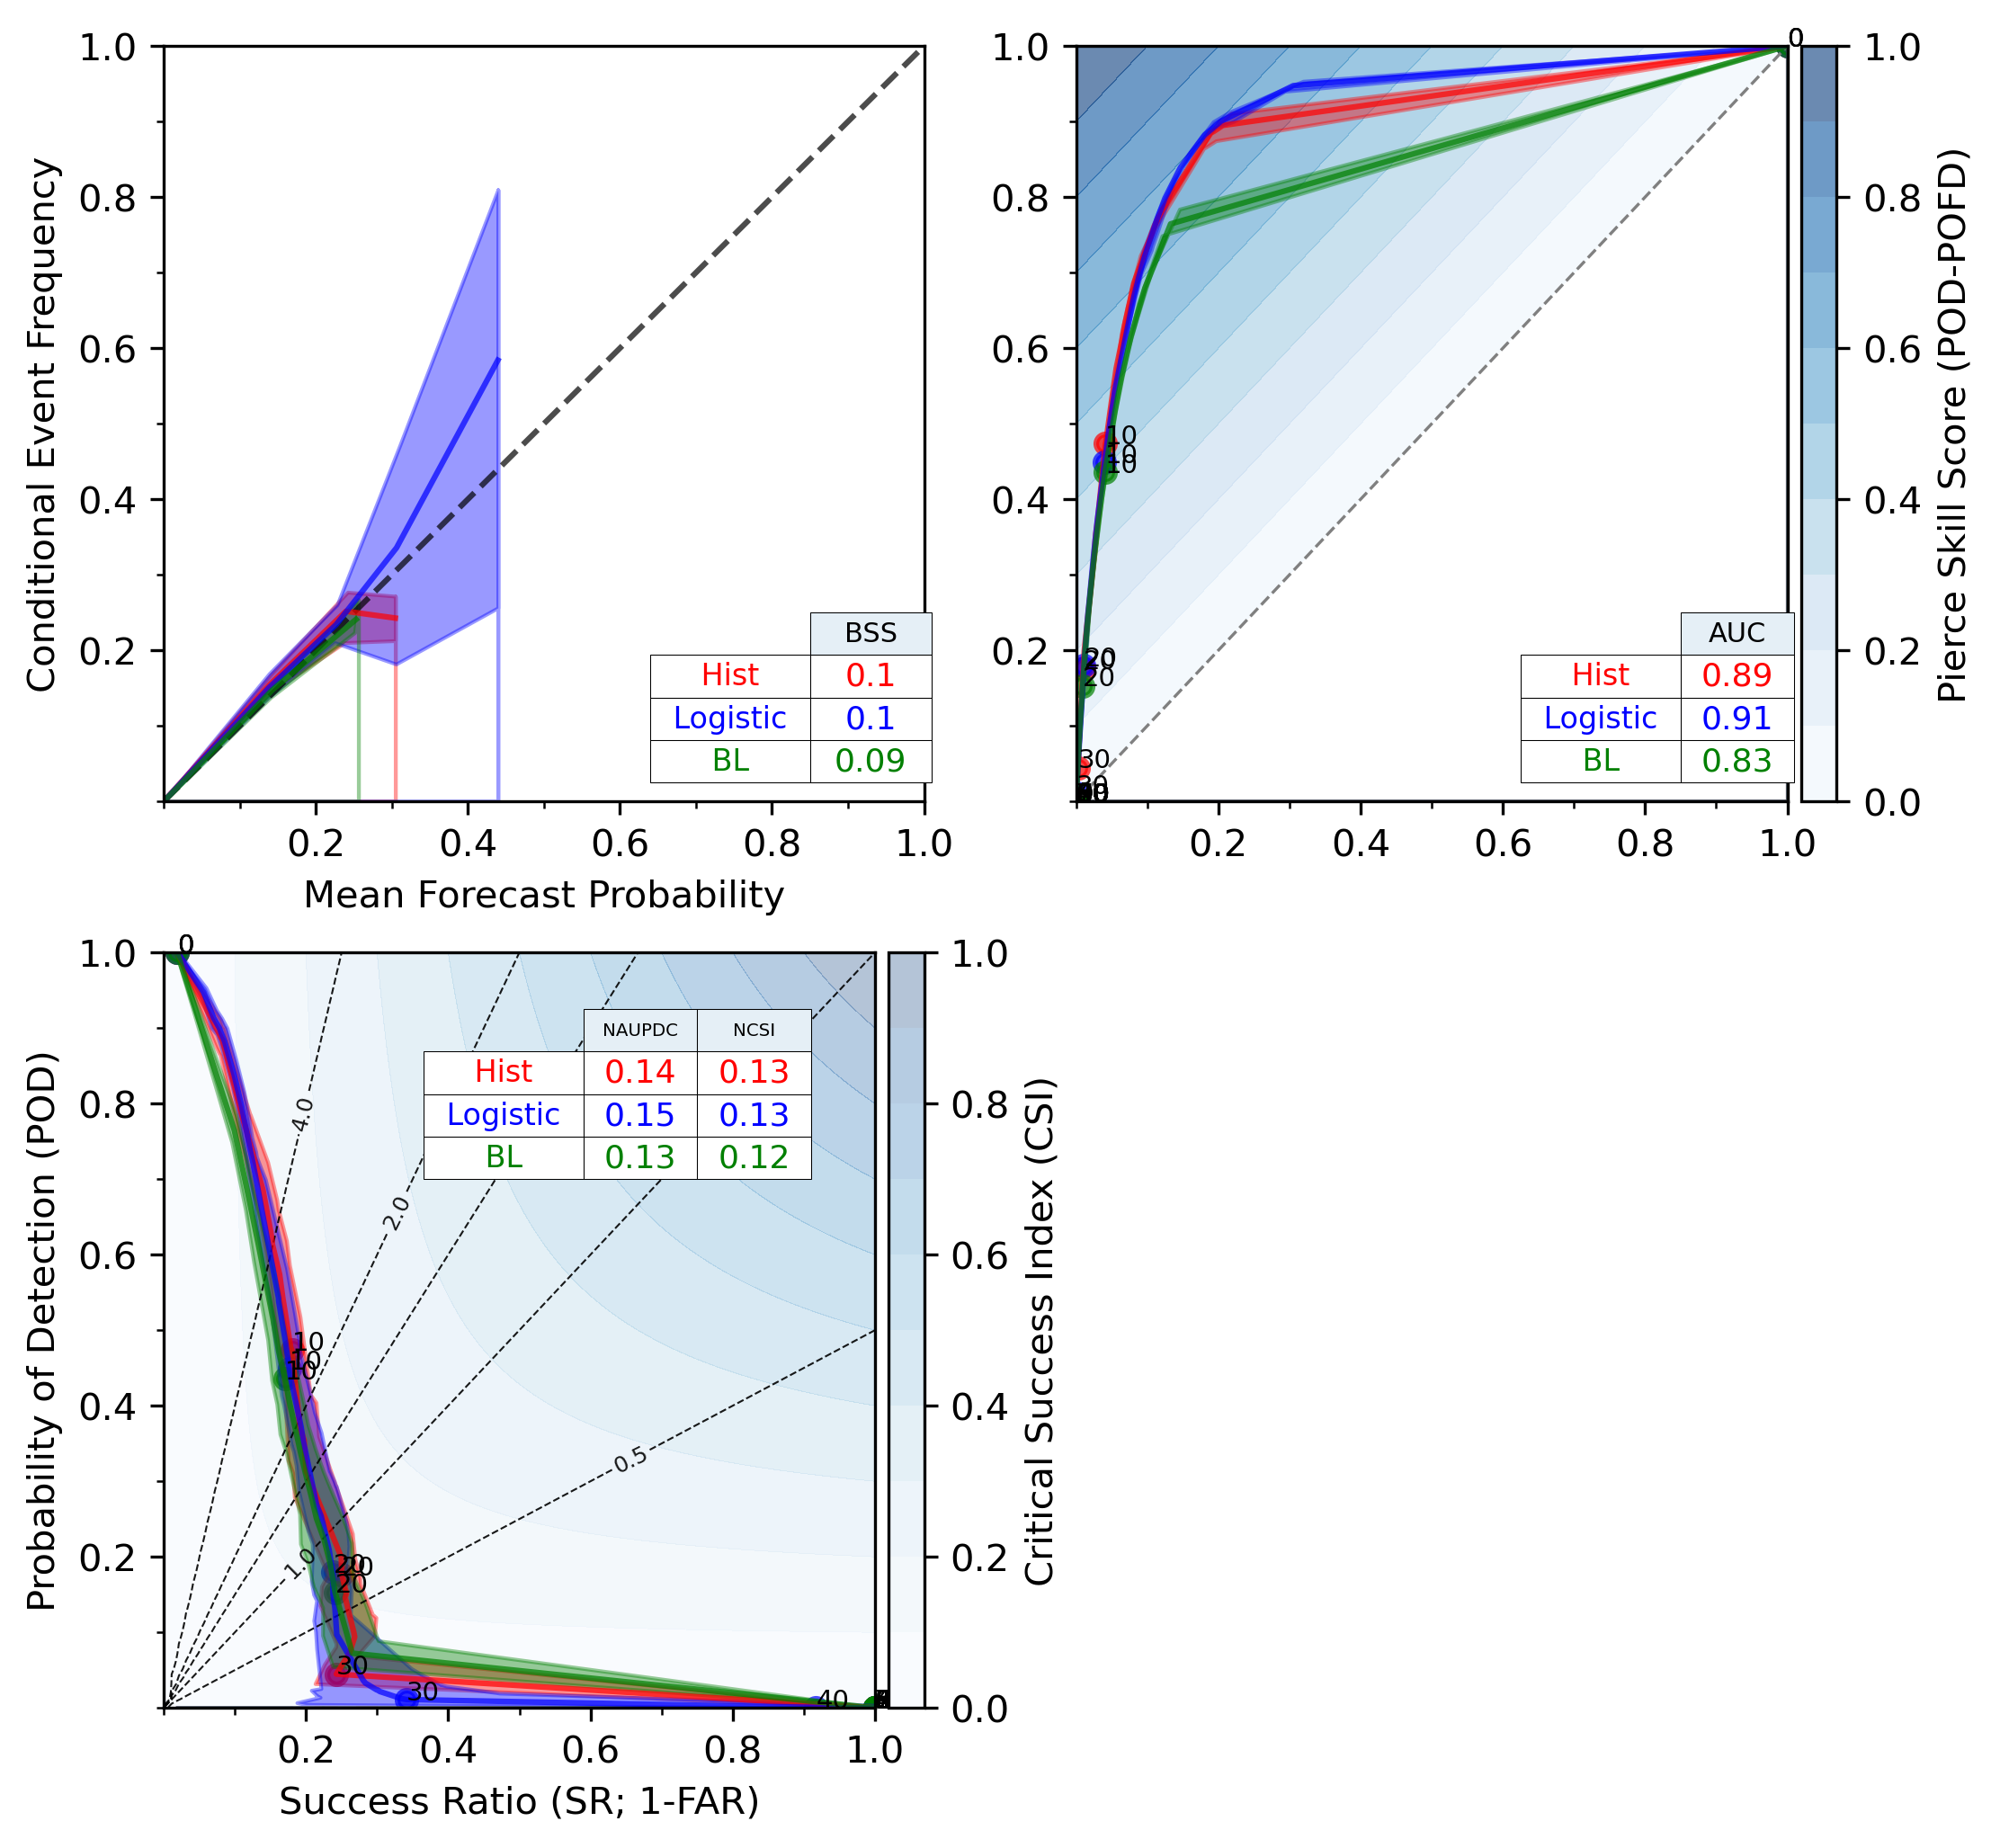

In [143]:
# Since X_bl and y are dataframe, we convert them to numpy.arrays 
# by using .values method. 
#plot_verification(estimators = estimators, 
#                  baseline_estimators = [('BL', bl_model)], 
#                  X = X, 
#                  X_baseline = X_bl.values, 
#                  y=y.values,
#                  n_boot=10,
#                  row_colors=['r','b','orange','k']#'r','b','g','orange','purple','k']
#                 )

plot_verification(y_true=y.values, y_pred=y_hat, names=[est[0] for est in estimators],
                      n_boot=30, style='classification', groups=groups)

# Uncomment and modify the filename to save the figure. 
#plt.savefig(f'{target_col}.png')


In [58]:
print(np.mean(y)*100)

2.1410087398076265


In [32]:
#dir(estimators[4][1])
#print(estimators[4][1].est_names)
#print(estimators[4][1].weights_)

AttributeError: 'IsotonicRegression' object has no attribute 'est_names'